# IEM 510 Project

### Project members: Jayesh Yevale \& Prerna Rathi

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import seaborn as sb
from math import *
import time
import random 
from numpy import linalg as LA
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score
import copy
import warnings
import pickle
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams.update({"text.usetex": True})

\begin{align*}
&\underset{{x \in \mathbb{R}^n}}{\mathrm{minimize}} \quad f(x) \qquad &&\hbox{where } f(x) \triangleq \frac{1}{|\mathcal{S}|}{\sum_{\ell \in \mathcal{S}}} \ln \left(1+\exp\left(-v_\ell u_\ell^Tx\right)\right)+\frac{\mu}{2}\|x\|^2\\
&\underset{{x \in \mathbb{R}^n}}{\mathrm{minimize}}\quad \sum_{i=1}^m f_i(x) \qquad &&\hbox{where } f_i(x)\triangleq \frac{1}{|\mathcal{S}|}\sum_{\ell \in \mathcal{S}_i}\ln \left(1+\exp\left(-v_\ell u_\ell^Tx\right)\right)+\frac{\mu}{2m}\|x\|^2,
\end{align*}
where $\ell$ denotes the index of a sample from the set $\mathcal{S}_i$.

\begin{align}
\nabla f_i(x) = \frac{1}{|\mathcal{S}|}\sum_{\ell\in\mathcal{S}_i} \frac{-v_\ell u_\ell}{\left(1+\exp\left(v_\ell u_\ell^Tx\right)\right)} + \frac{\mu}{m} x,
\end{align}

#### Download and reformat MNIST dataset

In [8]:
mnist = fetch_openml('mnist_784', version=1)
U0, v0 = mnist["data"], mnist["target"]
U= U0.astype(np.double)
v = v0.astype(np.uint8)

#### Change labels to {-1,+1} for binary classification 

In [9]:
v_bin_5_lst = [2*int(v[i]==5)-1 for i in range(len(v))]

#### Create a single dataframe of the attributes and labels

In [10]:
df_U = pd.DataFrame(data=U)
df_v = pd.DataFrame(data=np.asarray(v_bin_5_lst),  columns=['label'])
df_data_merged =pd.concat([df_U, df_v.reindex(df_U.index)], axis=1)
#df_data_merged.head()

In [162]:
n_attributes = 1000
n_labels = 50000
np.random.seed(1)
mu, sigma = 1,0.5

rnd_data = np.random.normal(mu, sigma, size=[n_labels,n_attributes])
rnd_labels = 2*np.reshape(np.random.randint(2, size=n_labels),(n_labels,1)) - np.ones((n_labels,1))
df_rnd_data = pd.DataFrame(data=rnd_data )
#df_rnd_labels = pd.DataFrame(data=np.asarray(v_bin_5_lst),  columns=['label'])
df_rnd_labels = pd.DataFrame(data=rnd_labels,  columns=['label'])
df_data_merged_rnd =pd.concat([df_rnd_data, df_rnd_labels.reindex(df_rnd_data.index)], axis=1)
#df_data_merged_rnd.head()

#### Shuffle and split the data to $m$ local training sets and a test set

In [12]:
def split_train_test(df_data_merged, train_set_size,test_set_size,m):
    np.random.seed(0)
    shuffled_indices = np.random.permutation(len(df_data_merged))
    batch_size = int(train_set_size/m)
    dic_train_sets_indices= {}
    dic_train_sets = {}
    for i in range(m):
        dic_train_sets_indices[i] = shuffled_indices[i*batch_size:(i+1)*batch_size]
        dic_train_sets[i] = df_data_merged.iloc[dic_train_sets_indices[i]]
    dic_train_set = {}
    dic_train_set_indices = shuffled_indices[:m*batch_size]
    dic_train_set[0] = df_data_merged.iloc[dic_train_set_indices]
    dic_test_set= {}
    test_indices = shuffled_indices[-test_set_size:]
    dic_test_set[0] = df_data_merged.iloc[test_indices]
    return dic_train_set, dic_train_sets, dic_test_set

#### Choose the communication network 

In [60]:
def W_matrix(graph_name,m):
    output = np.zeros((m,m))
    if m==1:
        output =np.array([[1]])
    elif graph_name == "Ring":
        for i in range(m):
            output[i,i]=(5/(1+5)) #0.5
            #output[i, np.remainder(i+1,m)]=(1/(1+5)) #0.25
            output[np.remainder(i+1,m) ,i]=(1/(1+5)) #0.25
    elif graph_name == "Complete":
        output = np.ones((m,m))/(m+4) #np.ones((m,m))/(2*(m-1))
        for i in range(m):
            output[i,i]= (5/(m+4))   #0.5
        #output = np.ones((m,m))/m 
    elif graph_name == "Line":
        for i in range(m-1):
            output[i,i]=0.5
            output[i+1 ,i]=0.5
        output[0,0]=1
        output[m-1,m-1]=0.5
        output[2,1]=0
        output[2,2]=1
    else:
        print("The graph name is unknown!")
    return output

We used metropolitian rule for assigning the weights ($w_{i,j}$) above.

#### Average function for computing Mean of samples

In [87]:
def average(x, epoch_size):
    avg= np.zeros(epoch_size+1)
    for e in range(epoch_size+1):
        avg[e] = np.mean(x[e,:])
    return avg

#### Define global objective function and local gradient mappings

Note that the *split_train_test* function returns **dataframes** of size **(labels $\times$ attrs)**.

In [198]:
def f_obj_global(x,dic_train,mu_param,m):
    output = sum([f_obj_local(x,dic_train[i],mu_param,m) for i in range(m)])
    return output

def f_obj_local(y,df_data,mu_param,m):
    npar_data= (df_data).to_numpy()
    nparr_data_transp = npar_data.T
    data = nparr_data_transp[:-1,:]
    labels =nparr_data_transp[-1:,:]
    n_attributes,n_labels = np.shape(data)
    x=y.reshape((n_attributes,1))
    v1 = np.dot(data.T,x) 
    v2 = -np.multiply(labels.T,v1)
    obj_val = 0
    obj_val = sum([v2[i,0] if v2[i,0] > 709 else log(1+exp(v2[i,0])) for i in range(n_labels)])
    output = obj_val/N + mu_param*np.dot(x.T,x)/(2*m)
    return output

def grad_f_local(x,df_data,mu_param,m):
    npar_data= (df_data).to_numpy()
    nparr_data_transp = npar_data.T
    data = nparr_data_transp[:-1,:]
    labels =nparr_data_transp[-1:,:]
    n_attributes,n_labels = np.shape(data)
    output = np.zeros((n_attributes,1))
    output = sum(-(labels[0,i]/(1+exp(min(709,labels[0,i]*np.dot(data[:,i],x)))))*data[:,[i]] for i in range(n_labels)) 
    return output/N +mu_param*x/m

def grad_f_matrix(x_matrix,dic_train_sets,mu_param):
    (m,n) = np.shape(x_matrix)
    output = np.zeros((m,n))
    for i in range(m):
        x = x_matrix[i,:].reshape((n,1))
        grad_vec = grad_f_local(x,dic_train_sets[i],mu_param,m)
        output[i,:] = grad_vec.reshape((1,n))
    return output

def stoch_grad_f_local(x,df_data,mu_param,m,batch_size,batch_indx_row):
    npar_data= (df_data).to_numpy()
    nparr_data_transp = npar_data.T
    data = nparr_data_transp[:-1,:]
    labels =nparr_data_transp[-1:,:]
    n_attributes,n_labels = np.shape(data)
    output = np.zeros((n_attributes,1))
    output = sum(-(labels[0,i]/(1+exp(min(709,labels[0,i]*np.dot(data[:,i],x)))))*data[:,[i]] for i in batch_indx_row)
    return output/N +mu_param*x/m

def stoch_grad_f_matrix(x_matrix,dic_train_sets,mu_param,batch_size,batch_indx_matrix):
    (m,n) = np.shape(x_matrix)
    output = np.zeros((m,n))
    for i in range(m):
        x = x_matrix[i,:].reshape((n,1))
        grad_vec = stoch_grad_f_local(x,dic_train_sets[i],mu_param,m,batch_size,batch_indx_matrix[i,:])
        output[i,:] = grad_vec.reshape((1,n))
    return output


####  Define Algorithms

In [208]:
def DSGT(dic_train_sets,grad_update,epoch_size,x0,G_W_name,init_step_size,mu_param,batch_size,train_set_size,Gamma,samples):
    (m,n) = np.shape(x0)
    W = W_matrix(G_W_name,m)   
    f_vals = np.zeros([epoch_size+1,samples])
    consensus_err_vals = np.zeros([epoch_size+1,samples])
    max_iter = int(grad_update*(train_set_size/(m*batch_size)))
    for s in range(samples):
        x_matrix_next = x0
        batch_indx_matrix_next=np.random.randint(int(train_set_size/m), size=(m,batch_size))
        grad_f_matrix_next = stoch_grad_f_matrix(x_matrix_next,dic_train_sets,mu_param,batch_size,batch_indx_matrix_next)
        epoch_index = 0
        for k in range(max_iter+1):
            x_matrix_now = x_matrix_next
            grad_f_matrix_now = grad_f_matrix_next
            batch_indx_matrix_now=batch_indx_matrix_next
            batch_indx_matrix_next=np.random.randint(int(train_set_size/m), size=(m,batch_size))
            x_matrix_next = np.dot(W,x_matrix_now - np.dot(np.diag(init_step_size[0]/(k+Gamma)),grad_f_matrix_now))
            grad_f_matrix_next = np.dot(W,grad_f_matrix_now)+stoch_grad_f_matrix(x_matrix_next,dic_train_sets,mu_param,batch_size,batch_indx_matrix_next)-stoch_grad_f_matrix(x_matrix_now,dic_train_sets,mu_param,batch_size,batch_indx_matrix_now)
            if max_iter==0 or (k % ceil(max_iter/epoch_size)) == 0:
                if m == 1:
                    x_ave = x_matrix_now[0]
                else:
                    x_ave = x_matrix_now.mean(0)
                f_vals[epoch_index,s] = f_obj_global(x_ave,dic_train_sets,mu_param,m)
                consensus_err_vals[epoch_index,s] = LA.norm(x_matrix_now-np.dot(np.ones((m,1)),x_ave.reshape(1,n)))
                epoch_index += 1
    f_vals_fin = average(f_vals,epoch_size)
    consensus_err_vals_fin = average(consensus_err_vals,epoch_size)
    return x_matrix_next.mean(0), f_vals_fin, consensus_err_vals_fin

In [209]:
def SONATA(dic_train_sets,grad_update,epoch_size,x0,G_W_name,init_step_size,mu_param,train_set_size,Gamma,samples):
    (m,n) = np.shape(x0)
    W = W_matrix(G_W_name,m)   
    f_vals = np.zeros([epoch_size+1,samples])
    consensus_err_vals = np.zeros([epoch_size+1,samples])
    max_iter = grad_update
    for s in range(samples):
        x_matrix_next = x0
        grad_f_matrix_next = grad_f_matrix(x_matrix_next,dic_train_sets,mu_param) 
        epoch_index = 0
        for k in range(max_iter+1):
            x_matrix_now = x_matrix_next
            grad_f_matrix_now = grad_f_matrix_next
            x_matrix_next = np.dot(W,x_matrix_now - np.dot(np.diag(init_step_size[0]/(k+Gamma)),grad_f_matrix_now))
            grad_f_matrix_next = np.dot(W,grad_f_matrix_now)+ np.dot(W,grad_f_matrix(x_matrix_next,dic_train_sets,mu_param))-np.dot(W,grad_f_matrix(x_matrix_now,dic_train_sets,mu_param))
            if max_iter==0 or (k % ceil(max_iter/epoch_size)) == 0:
                if m == 1:
                    x_ave = x_matrix_now[0]
                else:
                    x_ave = x_matrix_now.mean(0)
                f_vals[epoch_index,s] = f_obj_global(x_ave,dic_train_sets,mu_param,m)
                consensus_err_vals[epoch_index,s] = LA.norm(x_matrix_now-np.dot(np.ones((m,1)),x_ave.reshape(1,n)))
                epoch_index += 1
    f_vals_fin = average(f_vals,epoch_size)
    consensus_err_vals_fin = average(consensus_err_vals,epoch_size)
    return x_matrix_next.mean(0), f_vals_fin, consensus_err_vals_fin

#### Assign the dataset and hyperparameters

In [231]:
epoch_size = 5
grad_updates = 10 
Gamma=10000
gamma_step = 10
mu_param = 10**(-2)
samples = 5

train_set_size,test_set_size = 1000,0 

In [232]:
data = [df_data_merged,df_data_merged_rnd]
name_data = ["MNIST","Synthetic"]
graph = ["Complete","Ring"]
agents= [5]
dataset = data[1]
data_name = name_data[1]
data_impl = dataset

#### Main Function

<Figure size 864x432 with 0 Axes>

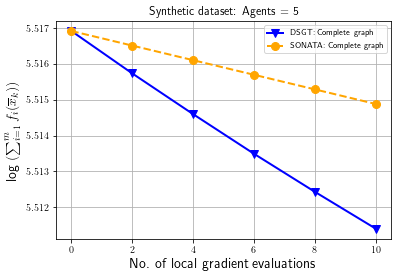

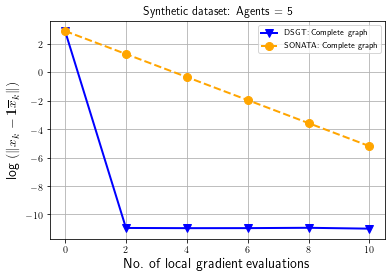

In [233]:
for k in range(len(agents)):
    m = agents[k]
    fig = plt.figure(figsize=(12,6))
    dic_train_set, dic_train_sets, dic_test_set = split_train_test(data_impl, train_set_size,test_set_size,m)
    n_attributes = len(data_impl.columns)-1
    N = train_set_size
    batch_size = 1
    
    init_step_size = gamma_step*np.ones((1,m))
    np.random.seed(123)
    x0_DRBSGT = np.random.rand(m,n_attributes) 
    np.random.seed(123)
    f_vals1 = np.zeros([epoch_size+1,samples])
    f_vals2 = np.zeros([epoch_size+1,samples])
    consensus_err_vals1 = np.zeros([epoch_size+1,samples])
    consensus_err_vals2 = np.zeros([epoch_size+1,samples])
    
    G_W_name = graph[0]  ### Complete Graph
    ### DSGT ###
    np.random.seed(123)
    x_sol1,f_vals1, consensus_err_vals1 = DSGT(dic_train_sets,grad_updates,epoch_size,x0_DRBSGT,
                                                 G_W_name,init_step_size,mu_param,batch_size,
                                                 train_set_size,Gamma,samples)
    np.random.seed(123)
    ### SONATA ###
    np.random.seed(123)
    x0_DSGT = x0_DRBSGT.copy()
    np.random.seed(123)
    x_sol2,f_vals2, consensus_err_vals2 = SONATA(dic_train_sets,grad_updates,epoch_size,x0_DSGT,
                                               G_W_name,init_step_size,mu_param,train_set_size,
                                                 Gamma,samples)
    np.random.seed(123)
    
    plt.figure()
    plt.title(data_name+" dataset: Agents = "+str(m))
    
    plt.plot(range(0,grad_updates+1,ceil(grad_updates/epoch_size)), np.log(f_vals1),color='blue',
         marker='v',markersize=8,linestyle='solid',label="DSGT: "+G_W_name+" graph",linewidth=2)
    plt.plot(range(0,grad_updates+1,ceil(grad_updates/epoch_size)), np.log(f_vals2),color='orange',
         marker='o',markersize=8,linestyle='dashed',label="SONATA: "+G_W_name+" graph",linewidth=2)
    plt.legend(loc=1,fontsize=8)
    
    plt.xlabel('No. of local gradient evaluations',fontsize = 14)
    plt.ylabel('log $(\sum_{i=1}^mf_i(\overline{x}_k))$', fontsize = 14)
    plt.grid(True)
    plt.show()
    plt.figure()
    plt.title(data_name+" dataset: Agents = "+str(m))
    
    plt.plot(range(0,grad_updates+1,ceil(grad_updates/epoch_size)), np.log(consensus_err_vals1),
             color='blue',marker='v',markersize=8,linestyle='solid',label="DSGT: "+G_W_name+" graph",linewidth=2)
    plt.plot(range(0,grad_updates+1,ceil(grad_updates/epoch_size)), np.log(consensus_err_vals2),
             color='orange',marker='o',markersize=8,linestyle='dashed',label="SONATA: "+G_W_name+" graph",linewidth=2)
    plt.legend(loc=1,fontsize=8)
    
    plt.xlabel('No. of local gradient evaluations',fontsize = 14) 
    plt.ylabel('log $(\|x_k - \mathbf{1}\overline{x}_k\|)$', fontsize = 14)
    plt.grid(True)
    #plt.savefig("Consensus.pdf")
    plt.show()

In [234]:
f_vals1

array([248.86448407, 248.57093177, 248.28932053, 248.01561416,
       247.75321455, 247.49929078])

In [235]:
f_vals2

array([248.86448407, 248.76344481, 248.66242656, 248.56142932,
       248.46045307, 248.3594978 ])

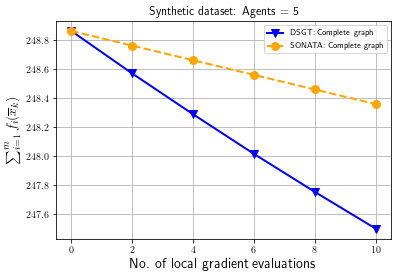

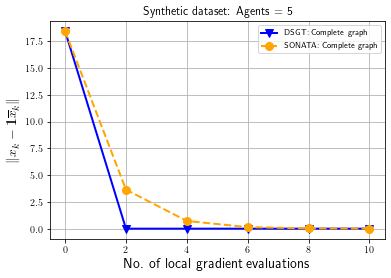

In [238]:
plt.figure()
plt.title(data_name+" dataset: Agents = "+str(m))

plt.plot(range(0,grad_updates+1,ceil(grad_updates/epoch_size)), (f_vals1),color='blue',
     marker='v',markersize=8,linestyle='solid',label="DSGT: "+G_W_name+" graph",linewidth=2)
plt.plot(range(0,grad_updates+1,ceil(grad_updates/epoch_size)), (f_vals2),color='orange',
     marker='o',markersize=8,linestyle='dashed',label="SONATA: "+G_W_name+" graph",linewidth=2)
plt.legend(loc=1,fontsize=8)

plt.xlabel('No. of local gradient evaluations',fontsize = 14)
plt.ylabel('$\sum_{i=1}^mf_i(\overline{x}_k)$', fontsize = 14)
plt.grid(True)
plt.show()
plt.figure()
plt.title(data_name+" dataset: Agents = "+str(m))

plt.plot(range(0,grad_updates+1,ceil(grad_updates/epoch_size)), (consensus_err_vals1),
         color='blue',marker='v',markersize=8,linestyle='solid',label="DSGT: "+G_W_name+" graph",linewidth=2)
plt.plot(range(0,grad_updates+1,ceil(grad_updates/epoch_size)), (consensus_err_vals2),
         color='orange',marker='o',markersize=8,linestyle='dashed',label="SONATA: "+G_W_name+" graph",linewidth=2)
plt.legend(loc=1,fontsize=8)

plt.xlabel('No. of local gradient evaluations',fontsize = 14) 
plt.ylabel('$\|x_k - \mathbf{1}\overline{x}_k\|$', fontsize = 14)
plt.grid(True)
#plt.savefig("Consensus.pdf")
plt.show()